# Assignment 6: Generative Adversarial Networks - Task 1

Submitted by: **Muhammad Ibrahim Afsar Khan**


Task 1:

- Implement a conditional DCGAN model (https://arxiv.org/abs/1411.1784)
- Train the model for conditional generation on the SVHN dataset
- Requirements:
    - Use Tensorboard, WandDB or some other experiment tracker
    - Show the capabilities of the model to generate data based on given label

## Prelimenaries

In [51]:
import numpy as np
import os
import shutil

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "conditional_DCGAN")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

## Dataset

In [55]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load SVHN dataset
train_dataset = datasets.SVHN(root='../data', split='train', download=True, transform=transform)
test_dataset = datasets.SVHN(root='../data', split='test', download=True, transform=transform)

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


In [56]:
BATCH_SIZE = 256

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [57]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

In [58]:
next(iter(test_loader))[0].shape

torch.Size([256, 3, 64, 64])

## Model

### Generator

In [59]:
class Generator(nn.Module):
    def __init__(self, nz, nc, ngf, n_classes):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, nz)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz * 2, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels).view(labels.size(0), -1, 1, 1)
        input = torch.cat((noise, label_embedding), dim=1)
        return self.main(input)


### Discriminator

In [60]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, n_classes):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, 64 * 64)
        self.main = nn.Sequential(
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels).view(labels.size(0), 1, 64, 64)
        input = torch.cat((img, label_embedding), dim=1)
        return self.main(input)


## Training

In [61]:
nz = 100  # Size of z latent vector (i.e. size of generator input)
nc = 3    # Number of channels in the training images (3 for RGB)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
n_classes = 10  # Number of classes (digits 0-9)

netG = Generator(nz, nc, ngf, n_classes).to(device)
netD = Discriminator(nc, ndf, n_classes).to(device)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch [1/25] Batch [286/287] Loss_D: 0.7983 Loss_G: 1.7116 D(x): 0.6306 D(G(z)): 0.2122 / 0.1946: 100%|█| 287/287 [00:28<00
Epoch [2/25] Batch [286/287] Loss_D: 1.1999 Loss_G: 4.7564 D(x): 0.8419 D(G(z)): 0.6254 / 0.0125: 100%|█| 287/287 [00:28<00
Epoch [3/25] Batch [286/287] Loss_D: 0.7453 Loss_G: 3.7672 D(x): 0.8317 D(G(z)): 0.4139 / 0.0334: 100%|█| 287/287 [00:28<00
Epoch [4/25] Batch [286/287] Loss_D: 1.0143 Loss_G: 3.5683 D(x): 0.7489 D(G(z)): 0.4822 / 0.0422: 100%|█| 287/287 [00:28<00
Epoch [5/25] Batch [286/287] Loss_D: 1.1077 Loss_G: 1.9844 D(x): 0.5348 D(G(z)): 0.1565 / 0.1854: 100%|█| 287/287 [00:28<00
Epoch [6/25] Batch [286/287] Loss_D: 0.7029 Loss_G: 2.2659 D(x): 0.6712 D(G(z)): 0.1691 / 0.1333: 100%|█| 287/287 [00:28<00
Epoch [7/25] Batch [286/287] Loss_D: 1.9260 Loss_G: 0.0792 D(x): 0.2418 D(G(z)): 0.0117 / 0.9252: 100%|█| 287/287 [00:29<00
Epoch [8/25] Batch [286/287] Loss_D: 0.5666 Loss_G: 7.5102 D(x): 0.9814 D(G(z)): 0.4142 / 0.0009: 100%|█| 287/287 [00:28<00
Epoch [9

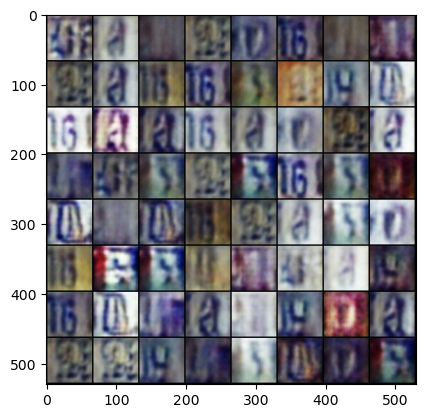

In [66]:
num_epochs = 25

for epoch in range(num_epochs):
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, data in progress_bar:
        # Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_cpu, labels = data
        batch_size = real_cpu.size(0)
        real_cpu = real_cpu.to(device)
        labels = labels.to(device)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        
        output = netD(real_cpu, labels).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise, labels)
        label.fill_(fake_label)
        
        output = netD(fake.detach(), labels).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake, labels).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 1 == 0:
            progress_bar.set_description(
                f'Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(train_loader)}] '
                f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}'
            )

    # Logging to Tensorboard
    writer.add_scalar('Loss/Discriminator', errD.item(), epoch * len(train_loader) + i)
    writer.add_scalar('Loss/Generator', errG.item(), epoch * len(train_loader) + i)
    
    # Save generated images
    with torch.no_grad():
        fake = netG(fixed_noise, torch.randint(0, n_classes, (64,), device=device))
        fake = (fake + 1) / 2
        grid = torchvision.utils.make_grid(fake, padding=2, normalize=True)
        writer.add_image('Generated Images', grid, epoch)

        if (epoch+1 == num_epochs):
            plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
            plt.show()

## Visualization

In [67]:
def generate_and_visualize_labels(generator, device, n_classes, nz=100, num_images_per_class=5):
    generator.eval()  # Set the generator to evaluation mode

    fig, axes = plt.subplots(n_classes, num_images_per_class, figsize=(num_images_per_class * 2, n_classes * 2))
    for label in range(n_classes):
        noise = torch.randn(num_images_per_class, nz, 1, 1, device=device)
        labels = torch.full((num_images_per_class,), label, dtype=torch.long, device=device)
        with torch.no_grad():
            generated_images = generator(noise, labels).cpu()
            generated_images = (generated_images + 1) / 2  # Rescale from [-1, 1] to [0, 1]
        
        for i in range(num_images_per_class):
            ax = axes[label, i]
            ax.imshow(np.transpose(generated_images[i], (1, 2, 0)))
            ax.axis('off')
            if i == 0:
                ax.set_ylabel(f'Label {label}', fontsize=12)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

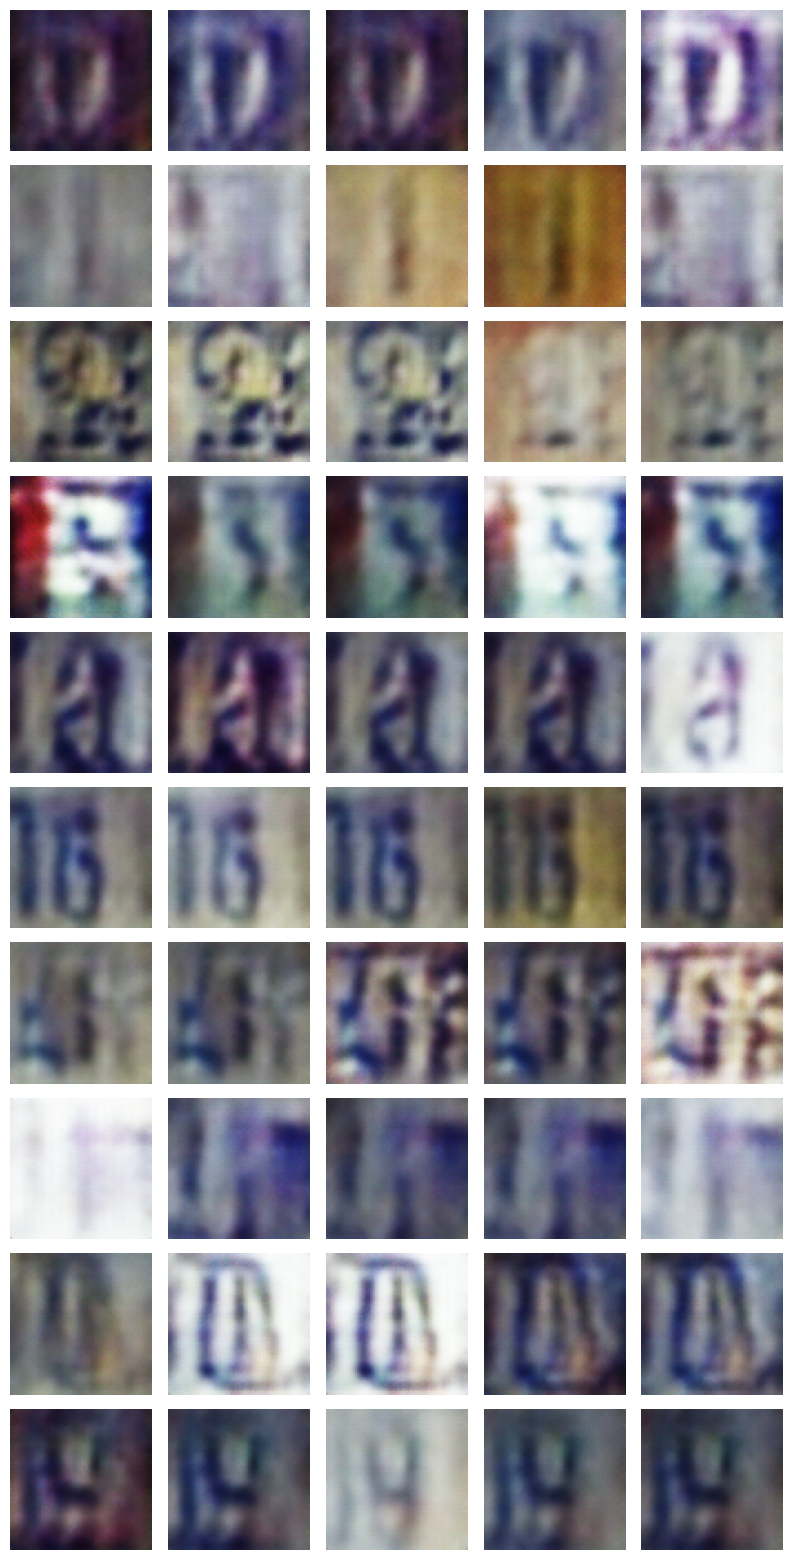

In [68]:
generate_and_visualize_labels(netG, device, n_classes, nz=100, num_images_per_class=5)